In the notebook `infermean_identify_highbias`, we tried to understand the cause of the positive bias in imputed mean temperatures.
We found that the imputations were particularly off on December 2nd at KBDL.
The true mean temperature on that day (17:00 UTC to to 17:00 UTC on December 2nd) was 3.375°C. 
The imputed mean temperature was 3.886°C ± 0.122: a >4σ error.

One hypothesis is that this is caused by the discrepancy between smoothmin and smoothmax, as on that the the temperatures stay low for a while.
We see a similar pattern (and magnitude of error) on June 2nd.

In [1]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Printf
using DataFrames
using JLD
using Dates
using GaussianProcesses: set_params!
import JSON
using Dates
using PDMats
using LinearAlgebra
using Statistics
using StatsBase: midpoints, Weights
using Distributions
using GaussianProcesses
using CmdStan
using Optim

GPmodel="matern"
ICAO="KBDL"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

5

In [3]:
using Revise
import TempModel

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/alternative_depots/climate/compiled/v1.1/TempModel/5V5SX.ji for TempModel [429a4ede-8e99-57b3-891e-c3971593d88c]
└ @ Base loading.jl:1184


In [4]:
module Batch
    using TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
#     include(joinpath(src_dir, "plot_map.jl"))
end

Main.Batch

In [5]:
# load kernel hyperparameters from JSON file
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", "crossval", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

In [6]:
hr_measure = Hour(17)
TnTx = TempModel.test_data(hourly_cat, itest, hr_measure)
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
# add column to test data for TnTx (useful for plotting)
hourly_test = join(hourly_test, TnTx, on=:ts_day)
;

# Optimizing posterior

In [34]:
test_fw = Batch.FittingWindow(Date(2015,10,20),Date(2016,1,1))
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir; crossval=true)
date_start = Date(2015,11,29)
impute_window = Day(7)
stan_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.01) # relaxed k, strict epsilon
;

In [8]:
L=LowerTriangular(stan_data["predicted_cov_chol"])

ksmoothmax = 10.0
epsilon = 0.01
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    L,
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
;

f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
@time opt_out = Optim.optimize(od, randn(pt.Nimpt); iterations=100000, f_tol=1e-14, x_tol=1e-12)

  6.535062 seconds (12.62 M allocations: 1.293 GiB, 8.91% gc time)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.936413503164634,-0.8933296400933126, ...]
 * Minimizer: [-0.007964946219947738,0.12024587294185098, ...]
 * Minimum: 5.373719e+00
 * Iterations: 10098
 * Convergence: true
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 1.55e-08 
   * |f(x) - f(x')| ≤ 1.0e-14 |f(x)|: true
     |f(x) - f(x')| = 6.94e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 7.83e-04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 30757
 * Gradient Calls: 30757

In [9]:
q = Optim.minimizer(opt_out)
temp_impute = pt.μ + pt.chol*q;

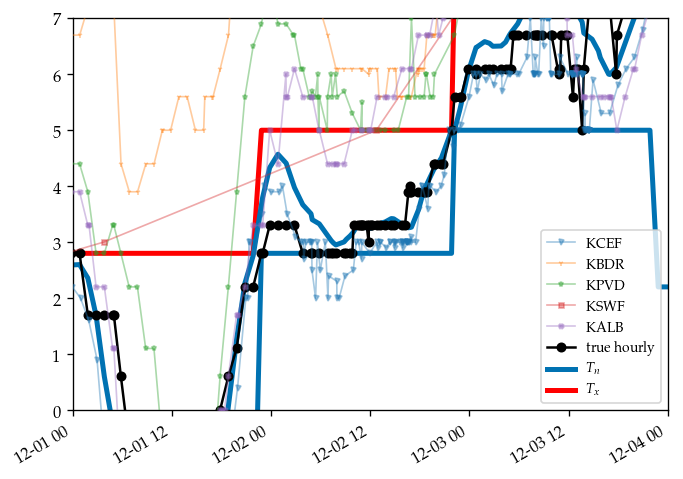

In [10]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=3)
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

Now steepen k:

In [36]:
ksmoothmax = 50.0
epsilon = 0.1
L=LowerTriangular(stan_data["predicted_cov_chol"])
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    L,
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
opt_out_steep = Optim.optimize(od, Optim.minimizer(opt_out); iterations=100000, f_tol=1e-16, x_tol=1e-12) 

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.007964946219947738,0.12024587294185098, ...]
 * Minimizer: [-0.0078748209533184,0.12049403198985358, ...]
 * Minimum: 4.779831e+00
 * Iterations: 11328
 * Convergence: true
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 1.37e-08 
   * |f(x) - f(x')| ≤ 1.0e-16 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.26e-05 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 34983
 * Gradient Calls: 34983

In [37]:
q = Optim.minimizer(opt_out_steep)
temp_steep = pt.μ + pt.chol*q;

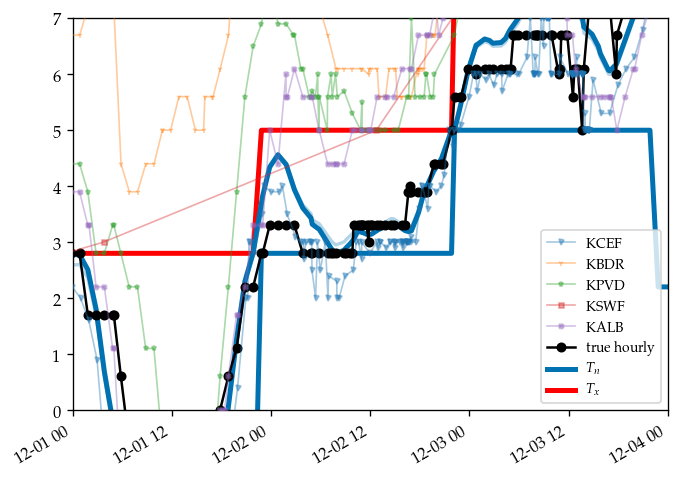

In [38]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=2, alpha=0.3)
plt.plot(local_time.(ts_window), temp_steep, color=cbbPalette[5], linewidth=3)
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

In [14]:
december2 = hourly_test[hourly_test[:ts_day] .== Date(2015,12,2), :]
true_mean_december2 = mean(december2[:temp])

3.375510204081634

In [15]:
impute_december2 = temp_impute[[t ∈ december2[:ts] for t in ts_window]]
mean(impute_december2) - mean(december2[:temp])

0.17095244103728424

In [16]:
impute_december2 = temp_steep[[t ∈ december2[:ts] for t in ts_window]]
mean(impute_december2) - mean(december2[:temp])

UndefVarError: UndefVarError: temp_steep not defined

The error is 0.09°C. With the posterior standard deviation of 0.16, that's a 0.5σ error, much less than the posterior mean (3.2σ error at best).
Is it worth exploring initialising Stan at the optimum?

# June 1st

In [39]:
test_fw = Batch.FittingWindow(Date(2015,5,2),Date(2015,7,14))
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir; crossval=true)
date_start = Date(2015,5,28)
impute_window = Day(7)
stan_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.01) # relaxed k, strict epsilon
;

In [40]:
true_temp = hourly_test[
    argmin(abs.(nearby_pred.ts[1]   .- hourly_test[:ts])):argmin(abs.(nearby_pred.ts[end] .- hourly_test[:ts])),
    :][:temp];

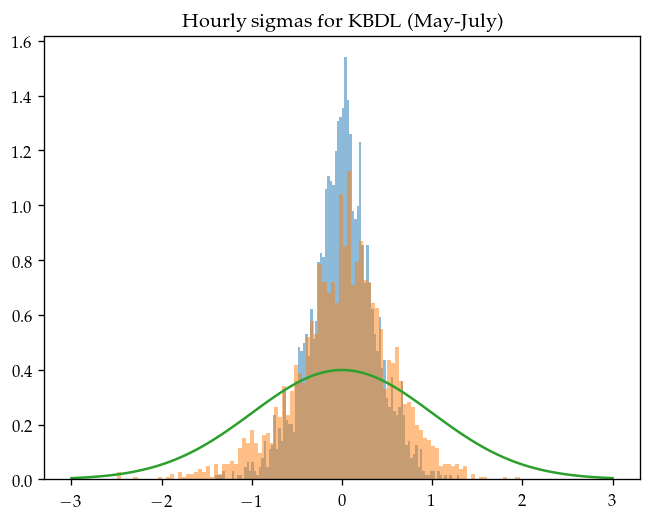

In [43]:
let
    nearby = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir; crossval=false)
    Σ = nearby.Σ
    nobsv = length(true_temp)
    centering = Matrix(1.0I, nobsv, nobsv) .- (1.0/nobsv)
    Σ_centered = centering * Σ.mat * centering
    error = nearby.μ .- true_temp
    meancorrected_error = error .- mean(error)
    plt.plt[:hist](meancorrected_error ./ diag(Σ_centered), normed=true, bins=100, alpha=0.5)
end

let
    nearby = nearby_pred
    Σ = nearby.Σ
    nobsv = length(true_temp)
    centering = Matrix(1.0I, nobsv, nobsv) .- (1.0/nobsv)
    Σ_centered = centering * Σ.mat * centering
    error = nearby.μ .- true_temp
    meancorrected_error = error .- mean(error)
    plt.plt[:hist](meancorrected_error ./ diag(Σ_centered), normed=true, bins=100, alpha=0.5)
end
xx = range(-3,stop=3,length=100)
plt.plot(xx, pdf.(Normal(), xx))
plt.title("Hourly sigmas for KBDL (May-July)")
;

In [21]:
L=LowerTriangular(stan_data["predicted_cov_chol"])
PDMats.PDMat(nearby_pred.Σ.mat[756:1038,756:1038]).chol.L == L

true

In [42]:
L=LowerTriangular(stan_data["predicted_cov_chol"])

ksmoothmax = 10.0
epsilon = 0.01
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    L,
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
;

f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
@time opt_out = Optim.optimize(od, randn(pt.Nimpt); iterations=100000, f_tol=1e-14, x_tol=1e-12)

  2.881487 seconds (2.86 M allocations: 1.080 GiB, 7.35% gc time)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [1.241591035410098,0.4021718282505108, ...]
 * Minimizer: [-0.06942208598432596,-0.028420195792151843, ...]
 * Minimum: 7.940240e+00
 * Iterations: 12483
 * Convergence: true
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 5.44e-08 
   * |f(x) - f(x')| ≤ 1.0e-14 |f(x)|: true
     |f(x) - f(x')| = 6.94e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 5.89e-04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 37363
 * Gradient Calls: 37363

In [44]:
q = Optim.minimizer(opt_out)
temp_impute = pt.μ + pt.chol*q;

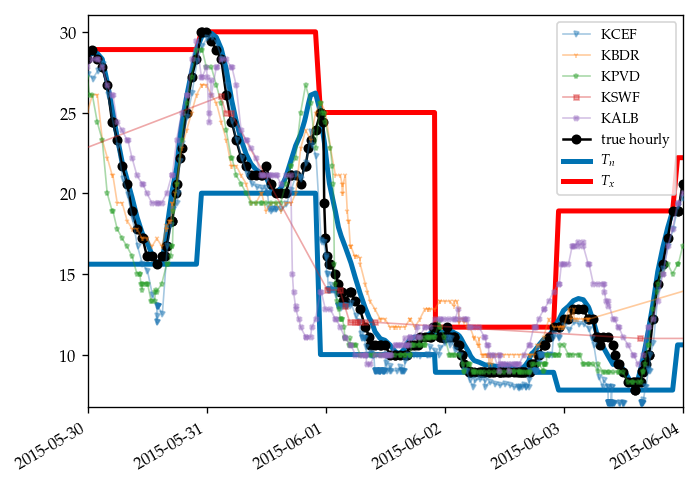

In [45]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=3)
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,5,30),Date(2015,6,4))
# plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,2),DateTime(2015,7,14));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,2),DateTime(2015,7,14))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

Now steepen k:

In [46]:
ksmoothmax = 50.0
epsilon = 0.1
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    L,
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
opt_out_steep = Optim.optimize(od, Optim.minimizer(opt_out); iterations=100000, f_tol=1e-16, x_tol=1e-12) 

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.06942208598432596,-0.028420195792151843, ...]
 * Minimizer: [-0.06687925708363515,-0.035306747010701495, ...]
 * Minimum: 7.471949e+00
 * Iterations: 2896
 * Convergence: true
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 7.87e-09 
   * |f(x) - f(x')| ≤ 1.0e-16 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 8.77e-05 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 8885
 * Gradient Calls: 8885

In [47]:
q = Optim.minimizer(opt_out_steep)
temp_steep = pt.μ + pt.chol*q;

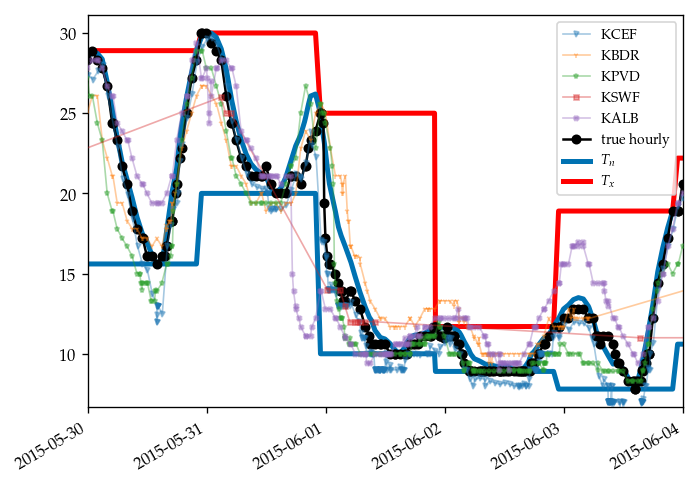

In [48]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=2, alpha=0.3)
plt.plot(local_time.(ts_window), temp_steep, color=cbbPalette[5], linewidth=3)
plt.xlim(Date(2015,5,30),Date(2015,6,4))
# plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,2),DateTime(2015,7,14));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,2),DateTime(2015,7,14))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
plt.gcf()[:autofmt_xdate]()
;

In [49]:
june1 = hourly_test[hourly_test[:ts_day] .== Date(2015,6,1), :]
true_mean_june1 = mean(june1[:temp])

13.378260869565224

In [50]:
impute_june1 = temp_impute[[t ∈ june1[:ts] for t in ts_window]]
mean(impute_june1) - mean(june1[:temp])

1.4924046067318937

In [51]:
impute_june1 = temp_steep[[t ∈ june1[:ts] for t in ts_window]]
mean(impute_june1) - mean(june1[:temp])

1.5346633235100615

Meanwhile the mean imputed error from Stan imputations is 1.62, with a posterior standard deviation of 0.40 (leading to a 4σ error).
So the optimal imputation is ever so slightly better, but still pretty much a 4σ error.

# Adding a local SEIso kernel

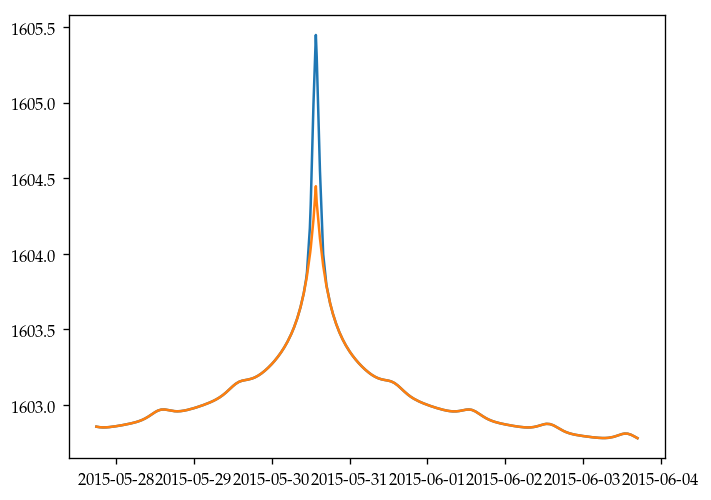

In [101]:
using GaussianProcesses
k_short = SEIso(log(1.0), log(1.0))

ts_window_hours = (ts_window .- ts_window[1]) ./ Millisecond(1) ./ (3600e3)

Σpred = stan_data["predicted_cov"]
Σmod = Σpred.+ cov(k_short, ts_window_hours')
plt.plot(ts_window, Σmod[100,:])
plt.plot(ts_window, Σpred[100,:])
Lmod = PDMats.PDMat(Σmod).chol.L
;

In [102]:
ksmoothmax = 50.0
epsilon = 0.1
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    Lmod,
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
opt_out_mod = Optim.optimize(od, Optim.minimizer(opt_out); iterations=100000, f_tol=1e-16, x_tol=1e-12) 

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.06942208598432596,-0.028420195792151843, ...]
 * Minimizer: [-0.06627359057998644,-0.06318103420189403, ...]
 * Minimum: 4.095421e+00
 * Iterations: 1008
 * Convergence: false
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 1.47e-08 
   * |f(x) - f(x')| ≤ 1.0e-16 |f(x)|: false
     |f(x) - f(x')| = 1.30e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.68e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3191
 * Gradient Calls: 3191

In [103]:
q = Optim.minimizer(opt_out_mod)
temp_mod = pt.μ + pt.chol*q;

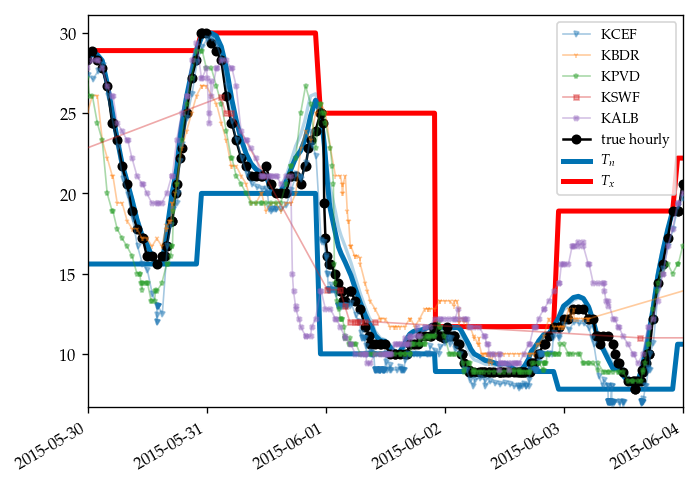

In [100]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=2, alpha=0.3)
# plt.plot(local_time.(ts_window), temp_steep, color=cbbPalette[5], linewidth=3)
plt.plot(local_time.(ts_window), temp_mod, color=cbbPalette[5], linewidth=3)
plt.xlim(Date(2015,5,30),Date(2015,6,4))
# plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,2),DateTime(2015,7,14));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,2),DateTime(2015,7,14))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
plt.gcf()[:autofmt_xdate]()
;

This basically fixes the problem. 
By allowing the model to exploit a short-scale kernel
essentially for free, the spatiotemporal model can focus on agreeing with its neighbours, while this short-term kernel is left to make adjustments to hit $T_n$ and $T_x$.
Now, this is kind of cheating: we have no justification for adding this short-term local kernel with high variance.
But the hope would be that by adding local components to the spatiotemporal kernels, the model would use these to model local deviations from the regional trends.